In [166]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Algoritma LSTM

In [167]:
# Load libraries
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense,
    Dropout, GRU, Bidirectional
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.) Dataset

In [168]:
# Baca Datasets
data = pd.read_csv("/content/tweet.csv")

In [169]:
plt.style.use("grayscale")

In [219]:
data.tail()

,Unnamed: 0,sentimen,tweet,tweet_clean,tweet_sw,tweet_token_words,tweet_stemming,tweet_w2v_model
1810,1810,netral,Negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga dan mengedepankan ...,negarawan sejati sll bangga mengedepankan harg...,"[negarawan, sejati, sll, bangga, mengedepankan...",negarawan sejati sll bangga depan harga diri b...,"[-0.019270288, 0.035245713, 0.007315515, 0.002..."
1811,1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...,hrs ceramah di damai indonesiaku perekonomia...,hrs ceramah damai indonesiaku perekonomian mak...,"[hrs, ceramah, damai, indonesiaku, perekonomia...",hrs ceramah damai indonesia ekonomi makin baik...,"[-0.080471404, 0.11215684, 0.03700161, -0.0151..."
1812,1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...,mari bangun bangsa dgn mendukung perekonomian ...,bangun bangsa mendukung perekonomian negara be...,"[bangun, bangsa, mendukung, perekonomian, nega...",bangun bangsa dukung ekonomi negara sama pak j...,"[-0.02910452, 0.031052705, 0.019957831, -0.000..."
1813,1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...,bantu majukan perekonomian bangsa bersama pak ...,bantu majukan perekonomian bangsa bersama pak ...,"[bantu, majukan, perekonomian, bangsa, bersama...",bantu maju ekonomi bangsa sama pak jokowi yuk,"[-0.011546341, 0.009592126, 0.011437153, -0.00..."
1814,1814,netral,Pak @jokowi mengubah cara pandang ekonomi. Kin...,pak mengubah cara pandang ekonomi kini semua o...,pak mengubah cara pandang ekonomi kini semua o...,"[pak, mengubah, cara, pandang, ekonomi, kini, ...",pak ubah cara pandang ekonomi kini semua orang...,"[-0.35909405, 0.5690748, 0.21528092, -0.051598..."


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [172]:
data.isnull().sum()

Unnamed: 0    0
sentimen      0
tweet         0
dtype: int64

In [173]:
data['sentimen'].value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

# 2.) Natural Language Text Preprocessing

## Text Cleaning

### Stopwords, Punctuation, Case Folding

In [174]:
%%time

import re
import string
import pandas as pd

def clean_text(text):
    # Menghapus username Twitter (@username)
    text = re.sub(r'@\w+', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Menghapus karakter non-alfanumerik dan tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus karakter berulang
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Mengubah ke lowercase
    text = text.lower()

    return text

def remove(tweet):
    # Remove mention
    tweet = re.sub("@[A-Za-z0-9_]+", "", tweet)
    # Remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # Remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'^rt[\s]+', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'^https[\s]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'%', '', tweet)
    # Remove commas
    tweet = re.sub(r',', '', tweet)
    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)
    tweet = re.sub(r':', '', tweet)
    # Remove space
    tweet = tweet.strip()
    # Remove double space}
    tweet = re.sub('\s+', ' ', tweet)
    # Menghapus angka
    tweet = re.sub(r'\d+', '', tweet)

    # Menghapus tanda baca
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Cleaning text
    cleaned_tweet = clean_text(tweet)

    return cleaned_tweet

# Menerapkan fungsi remove dan clean_text pada kolom 'tweet' dan menyimpan hasilnya dalam kolom 'cleaning_data'
data['tweet_clean'] = data['tweet'].apply(lambda x: remove(x.lower()))

# Menampilkan hasil
print(data['tweet_clean'])

0       kata indonesia tidak dihargai bangsa asing ber...
1       batuan langka tasbih jokowi hadiah dari habib ...
2       di era jokowi ekonomi indonesia semakin baik i...
3       bagi sumatera selatan asian games berdampak pd...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811     hrs ceramah di damai indonesiaku  perekonomia...
1812    mari bangun bangsa dgn mendukung perekonomian ...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object
CPU times: user 131 ms, sys: 953 µs, total: 132 ms
Wall time: 136 ms


## Stopword Removal

In [175]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Stopword Tradisional

In [176]:
%%time

import re
import pandas as pd

def remove_stopwords(text):
    stopwords = ['yg','ðŸ','ðÿœ',"yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah']  # Ganti dengan stopwords tradisional sesuai kebutuhan

    # Menghapus karakter non-alfabet dan mengubah teks menjadi huruf kecil
    processed_text = re.sub(r'[^a-zA-Z]', ' ', text.lower())

    # Memisahkan kata-kata dalam teks
    words = processed_text.split()

    # Menghapus stopwords dari teks
    filtered_words = [word for word in words if word not in stopwords]

    # Menggabungkan kembali kata-kata yang telah di-filter
    filtered_text = ' '.join(filtered_words)

    return filtered_text

 #Menerapkan fungsi remove_stopwords pada kolom 'tweet_clean'
filtered_text = data['tweet_clean'].apply(remove_stopwords)

 #Menampilkan DataFrame hasil
print(filtered_text)


0       kata indonesia tidak dihargai bangsa asing ber...
1       batuan langka tasbih jokowi hadiah dari habib ...
2       di era jokowi ekonomi indonesia semakin baik i...
3       bagi sumatera selatan asian games berdampak pd...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811    hrs ceramah di damai indonesiaku perekonomian ...
1812    mari bangun bangsa mendukung perekonomian nega...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object
CPU times: user 54.9 ms, sys: 0 ns, total: 54.9 ms
Wall time: 57.2 ms


### Stopword Sastrawi

In [177]:
%%time
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re

def preprocess_text(text):
    # Buat instance dari StopWordRemoverFactory
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()

    # Menghapus karakter non-alfanumerik dan mengubah ke huruf kecil
    text = re.sub(r'\W+', ' ', text.lower())

    # Menghapus stopwords dari teks menggunakan Sastrawi
    text_tanpa_stopword = stopword_remover.remove(text)

    return text_tanpa_stopword

data['tweet_sw'] =filtered_text.apply(preprocess_text)

print(data['tweet_sw'])

0       kata indonesia dihargai bangsa asing berita pa...
1       batuan langka tasbih jokowi hadiah habib luthf...
2       era jokowi ekonomi indonesia semakin baik indo...
3       sumatera selatan asian games berdampak pd ekon...
4       negara ngutang buat bngun infrastruktur udah d...
                              ...                        
1810    negarawan sejati sll bangga mengedepankan harg...
1811    hrs ceramah damai indonesiaku perekonomian mak...
1812    bangun bangsa mendukung perekonomian negara be...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_sw, Length: 1815, dtype: object
CPU times: user 325 ms, sys: 2.84 ms, total: 328 ms
Wall time: 5.01 s


## Text Tokenization

### Word Tokenization

In [178]:
%%time
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Fungsi untuk tokenisasi kata
def tokenize_words(text):
    words = word_tokenize(text)
    return words

# Tokenisasi kata
data['tweet_token_words'] = data['tweet_sw'].apply(tokenize_words)
print("\nTokenisasi kata:")
print(data['tweet_token_words'])


Tokenisasi kata:
0       [kata, indonesia, dihargai, bangsa, asing, ber...
1       [batuan, langka, tasbih, jokowi, hadiah, habib...
2       [era, jokowi, ekonomi, indonesia, semakin, bai...
3       [sumatera, selatan, asian, games, berdampak, p...
4       [negara, ngutang, buat, bngun, infrastruktur, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, mengedepankan...
1811    [hrs, ceramah, damai, indonesiaku, perekonomia...
1812    [bangun, bangsa, mendukung, perekonomian, nega...
1813    [bantu, majukan, perekonomian, bangsa, bersama...
1814    [pak, mengubah, cara, pandang, ekonomi, kini, ...
Name: tweet_token_words, Length: 1815, dtype: object
CPU times: user 471 ms, sys: 4.77 ms, total: 476 ms
Wall time: 505 ms


In [179]:
from ast import literal_eval

# Parsing tokenize value in tweet_tokenize column
data['tweet_token_words'] = data['tweet_token_words'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

## Stemming

In [180]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#  Stemming

## Define objek stemming
stemmer = StemmerFactory()
stemmer = stemmer.create_stemmer()

In [181]:
from tqdm import tqdm
tqdm.pandas()  # Menggunakan decorator untuk menggabungkan 'tqdm' dengan Pandas

# Gunakan progress_apply setelah menggunakan tqdm.pandas()
data['tweet_stemming'] = data['tweet_token_words'].progress_apply(lambda x: " ".join(list(map(stemmer.stem, x))))

100%|██████████| 1815/1815 [08:54<00:00,  3.40it/s]


## EDA

### Distribusi Dari Review per Sentimen






In [182]:
plt.style.use("fivethirtyeight")


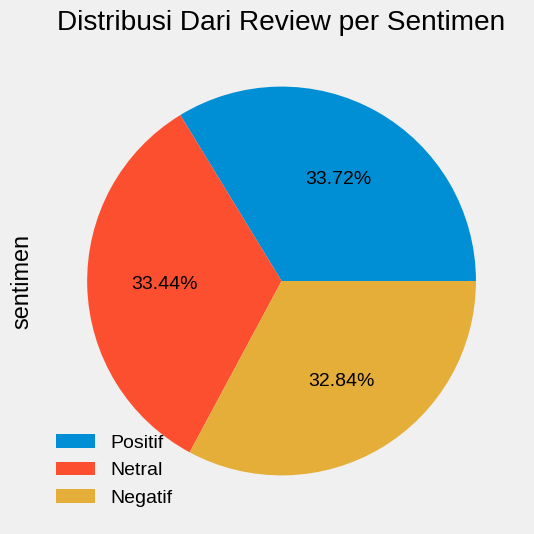

In [183]:
import matplotlib.pyplot as plt

data['sentimen'].value_counts().plot.pie(figsize=(6,6),title="Distribusi Dari Review per Sentimen",labels=['','',''],autopct='%1.2f%%')
labels=["Positif","Netral","Negatif"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

### Visualizing Word Clouds

In [184]:
from wordcloud import WordCloud

In [185]:
data_negatif = data[data['sentimen'] == "positif"]
data_positif = data[data['sentimen'] == "negatif"]
data_netral = data[data['sentimen'] == "netral"]

# Menggabungkan semua list menjadi satu list tunggal
all_frekuensi_list = [word for sublist in data['tweet_token_words'] for word in sublist]
negative_list = [word for sublist in data_negatif['tweet_token_words'] for word in sublist]
positive_list = [word for sublist in data_positif['tweet_token_words'] for word in sublist]
netral_list = [word for sublist in data_netral['tweet_token_words'] for word in sublist]

filtered_all_frekuensi = " ".join(all_frekuensi_list)  # Mengubah list menjadi string
filtered_all_frekuensi = filtered_all_frekuensi.lower()

filtered_negative = " ".join(negative_list)  # Mengubah list menjadi string
filtered_negative = filtered_negative.lower()

filtered_positive = " ".join(positive_list)  # Mengubah list menjadi string
filtered_positive = filtered_positive.lower()

filtered_neutral = " ".join(netral_list)  # Mengubah list menjadi string
filtered_neutral = filtered_neutral.lower()


#### Word Cloud : Frekuensi Semua Ulasan

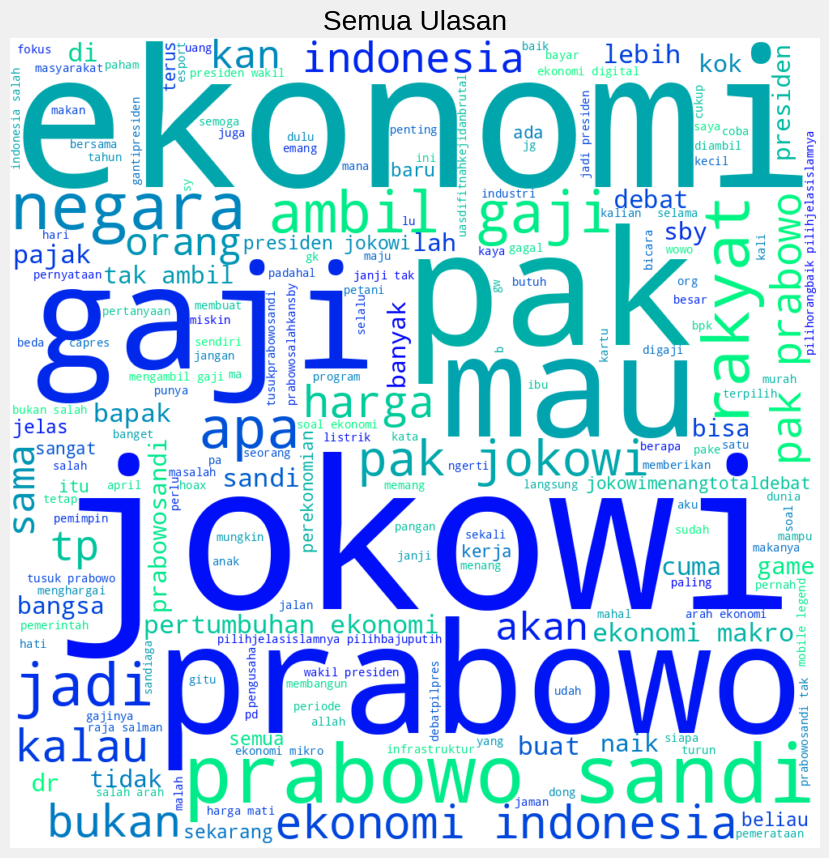

In [186]:
# Visualisasi frekuensi kemunculan kata

wordcloud = WordCloud(colormap='winter', width=1000, height=1000, mode='RGBA', background_color='white').generate(filtered_all_frekuensi)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Semua Ulasan")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud : Positive

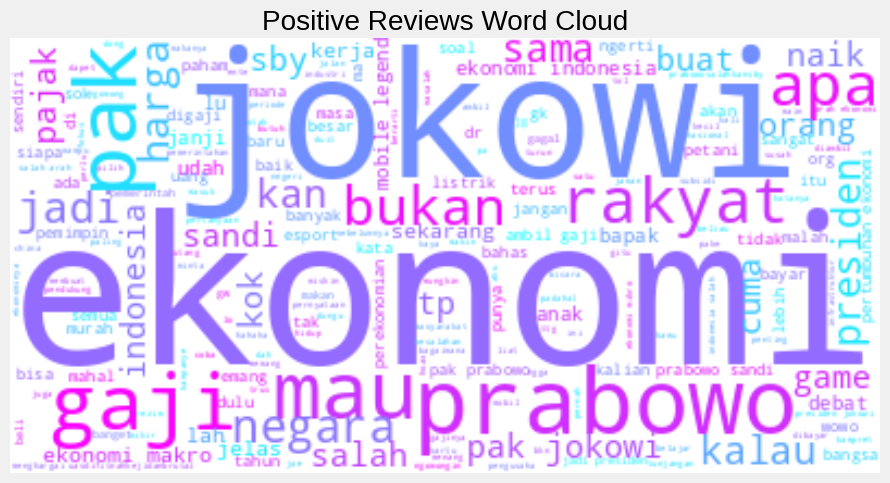

In [187]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="cool").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

#### Word Cloud : Negatif

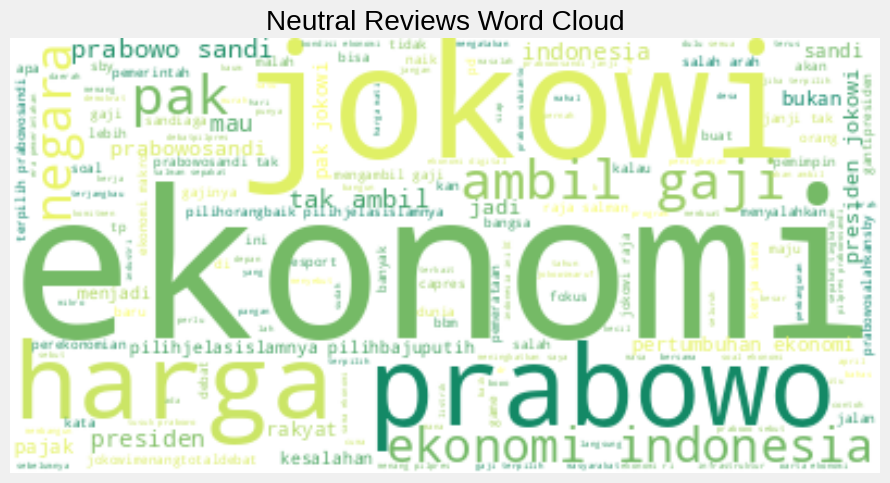

In [188]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="summer").generate(filtered_neutral)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Neutral Reviews Word Cloud")
plt.show()

#### Word Cloud : Netral

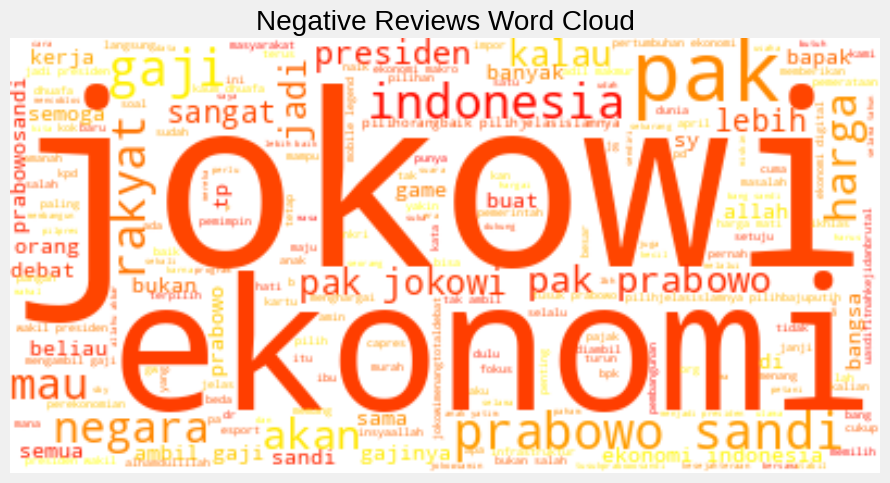

In [189]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="autumn").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

## Data Final

In [190]:
data.head()

,Unnamed: 0,sentimen,tweet,tweet_clean,tweet_sw,tweet_token_words,tweet_stemming
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata indonesia tidak dihargai bangsa asing ber...,kata indonesia dihargai bangsa asing berita pa...,"[kata, indonesia, dihargai, bangsa, asing, ber...",kata indonesia harga bangsa asing berita pasti...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah dari habib ...,batuan langka tasbih jokowi hadiah habib luthf...,"[batuan, langka, tasbih, jokowi, hadiah, habib...",batu langka tasbih jokowi hadiah habib luthfi ...
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",di era jokowi ekonomi indonesia semakin baik i...,era jokowi ekonomi indonesia semakin baik indo...,"[era, jokowi, ekonomi, indonesia, semakin, bai...",era jokowi ekonomi indonesia makin baik indone...
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",bagi sumatera selatan asian games berdampak pd...,sumatera selatan asian games berdampak pd ekon...,"[sumatera, selatan, asian, games, berdampak, p...",sumatera selatan asi games dampak pd ekonomi l...
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara kita ngutang buat bngun infrastruktur y...,negara ngutang buat bngun infrastruktur udah d...,"[negara, ngutang, buat, bngun, infrastruktur, ...",negara ngutang buat bngun infrastruktur udah d...


# 3.) Data Modeling

## Split Data Train dan Test

In [191]:
# Define Fitur dan Target
feature = data['tweet_stemming'].values
target  = data['sentimen'].values

In [192]:
# Transform string ke label
encoder = LabelEncoder()
target_encoder = encoder.fit_transform(target)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(feature, target_encoder, test_size = 0.3, random_state = 1)

# Check dimensi
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Transform text data ke data vektor
embedding = CountVectorizer()
embedding.fit(X_train)

# train test
X_train_vec = embedding.transform(X_train)
X_test_vec  = embedding.transform(X_test)

# Check dimensi dari text vectorizer
X_train_vec.shape, X_test_vec.shape

((1270, 4561), (545, 4561))

## Algoritma : LSTM

In [193]:
# Define max length
MAX_LENGTH = 250

## Preprocess text ke Tokenizer
embedding_tf = Tokenizer(num_words = 10_000)
embedding_tf.fit_on_texts(X_train)

X_train_embedding = embedding_tf.texts_to_sequences(X_train)
X_test_embedding  = embedding_tf.texts_to_sequences(X_test)

## One hot encoder
y_train_encoder = to_categorical(y_train)
y_test_encoder = to_categorical(y_test)

## Preprocess vectorized data dari stemmed sentences menggunakan pad_sequences
X_train_pad = pad_sequences(X_train_embedding, maxlen = MAX_LENGTH)
X_test_pad  = pad_sequences(X_test_embedding, maxlen = MAX_LENGTH)

X_test_pad = X_train_pad[:363]
y_test_encoder = y_train_encoder[:363]


In [194]:
# Buat Model LSTM dengan defined parameters
def buat_model_lstm(
    n_units_lstm: int = 64, max_words: int = 10_000,
    max_sequence: int = MAX_LENGTH, dropout_rate: float = 0.2,
    n_units_dense: int = 32, n_dense_layers: int = 2,
    output_dim: int = 250
    ):

    model = Sequential()
    model.add(Input(shape = [max_sequence]))
    model.add(Embedding(input_dim = max_words, output_dim = output_dim, input_length = max_sequence))
    model.add(Bidirectional(LSTM(n_units_lstm, return_sequences = False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation = "softmax"))

    return model

In [195]:
# Configure defined model
model = buat_model_lstm()

## Compile model with hyperparameters
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [196]:
## lihat model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 250)          2500000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              161280    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,661,667
Trainable params: 2,661,667
Non-trainable params: 0
_________________________________________________________________


In [197]:
# Define kostum callbacks
class OwnCallbacks(tf.keras.callbacks.Callback):

    def __init__(self, threshold = 0.95):
        super(OwnCallbacks, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [198]:
# Training model
history = model.fit(
    X_train_pad, y_train_encoder,
    batch_size = 16, epochs = 100,
    validation_data = (X_test_pad, y_test_encoder),
    callbacks = [OwnCallbacks()]
)

Epoch 1/100
80/80 [==============================] - 42s 470ms/step - loss: 1.0627 - accuracy: 0.4205 - val_loss: 0.9275 - val_accuracy: 0.5537
Epoch 2/100
80/80 [==============================] - 36s 446ms/step - loss: 0.7290 - accuracy: 0.7047 - val_loss: 0.3371 - val_accuracy: 0.8981
Epoch 3/100
80/80 [==============================] - 35s 438ms/step - loss: 0.3088 - accuracy: 0.8913 - val_loss: 0.1560 - val_accuracy: 0.9669


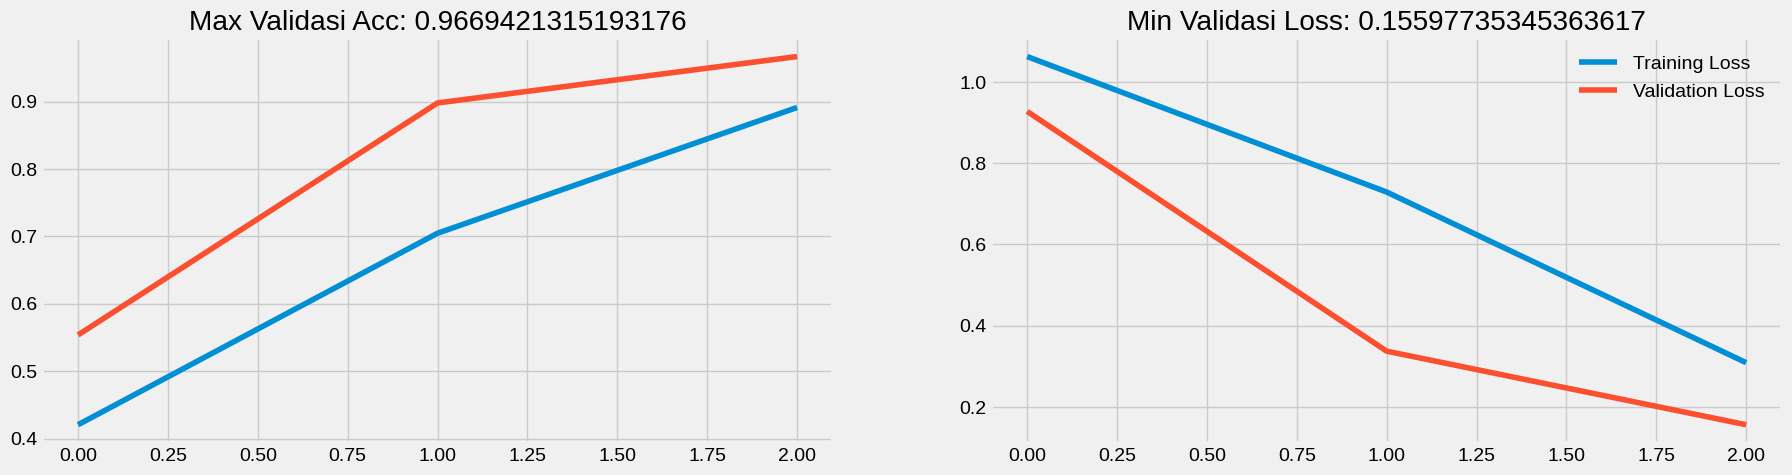

In [199]:
# Visualize plot training dan validasi
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
epochs = range(len(history.history['loss']))

ax[0].plot(epochs, history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(epochs, history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].set_title(f"Max Validasi Acc: {max(history.history['val_accuracy'])}")

ax[1].plot(epochs, history.history['loss'], label = "Training Loss")
ax[1].plot(epochs, history.history['val_loss'], label = "Validation Loss")
ax[1].set_title(f"Min Validasi Loss: {min(history.history['val_loss'])}")

plt.legend()
plt.show()

In [200]:
### Evaluate model on train set
pred = model.predict(X_train_pad).argmax(axis = 1)
true = y_train_encoder.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

40/40 [==============================] - 8s 185ms/step
              precision    recall  f1-score   support

     negatif       0.97      0.96      0.96       418
      netral       0.95      0.98      0.97       419
     positif       0.97      0.95      0.96       433

    accuracy                           0.96      1270
   macro avg       0.96      0.96      0.96      1270
weighted avg       0.96      0.96      0.96      1270



In [201]:
### Evaluate model on test set
pred = model.predict(X_test_pad).argmax(axis = 1)
true = y_test_encoder.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

12/12 [==============================] - 2s 139ms/step
              precision    recall  f1-score   support

     negatif       0.98      0.95      0.97       132
      netral       0.96      0.98      0.97       104
     positif       0.96      0.97      0.96       127

    accuracy                           0.97       363
   macro avg       0.97      0.97      0.97       363
weighted avg       0.97      0.97      0.97       363



# 4.) Model Evaluation

## Evaluasi Accuracy dan Loss

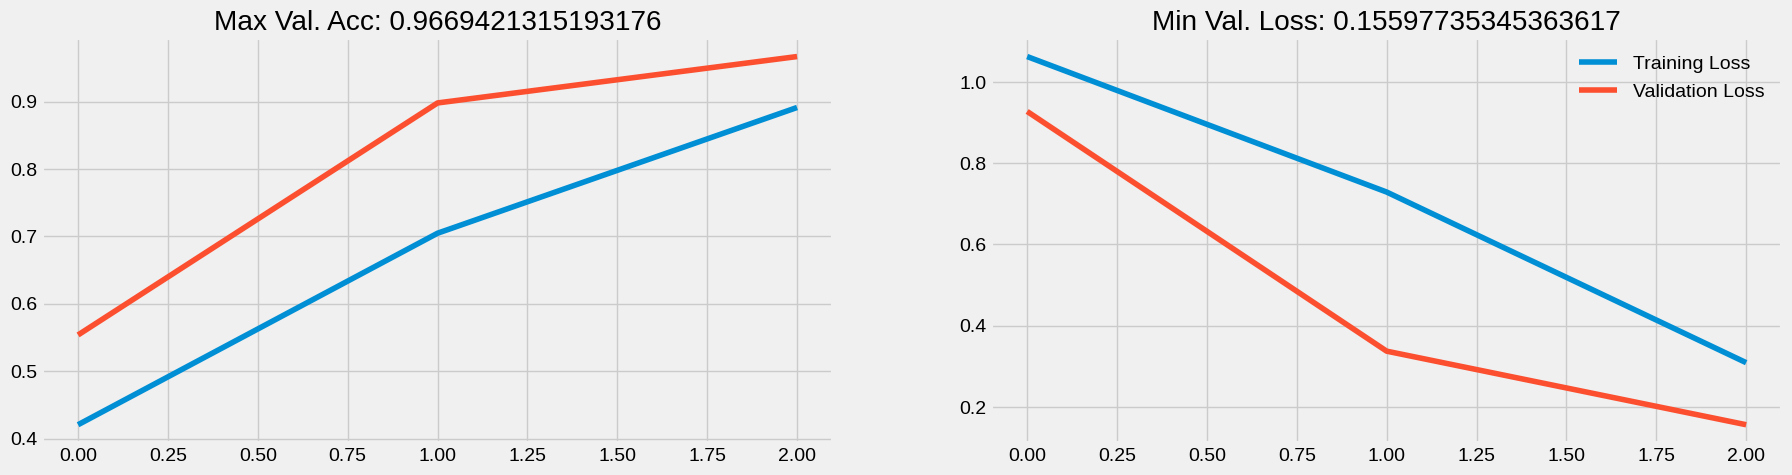

In [202]:
# Visualize plot training and validation
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
epochs = range(len(history.history['loss']))

ax[0].plot(epochs, history.history['accuracy'], label = "Training Accuracy")
ax[0].plot(epochs, history.history['val_accuracy'], label = "Validation Accuracy")
ax[0].set_title(f"Max Val. Acc: {max(history.history['val_accuracy'])}")

ax[1].plot(epochs, history.history['loss'], label = "Training Loss")
ax[1].plot(epochs, history.history['val_loss'], label = "Validation Loss")
ax[1].set_title(f"Min Val. Loss: {min(history.history['val_loss'])}")

plt.legend()
plt.show()

## Evaluasi Prediksi Sentimen

In [218]:
# Panggil fungsi predict dengan teks yang ingin Anda prediksi
predict("di era jokowi ekonomi indonesia semakin baik indonesiamaju jokowilagi jokowimenang total debat") # Aktual Positif

1/1 [==============================] - 0s 163ms/step
Sentimen: Negative
Waktu prediksi: 0.39333176612854004 detik


In [204]:
# Panggil fungsi predict dengan teks yang ingin Anda prediksi
predict("kata indonesia dihargai bangsa asing berita pasti hoax buatan penguasa ") # Aktual Negatif

1/1 [==============================] - 0s 35ms/step
Sentimen: Negative
Waktu prediksi: 0.09423494338989258 detik


In [220]:
# Panggil fungsi predict dengan teks yang ingin Anda prediksi
predict("negarawan sejati sll bangga mengedepankan harga diri bangsanya berdaulat gantipresiden") # Aktual Netral

1/1 [==============================] - 0s 144ms/step
Sentimen: Negative
Waktu prediksi: 0.36240100860595703 detik


In [222]:
# Panggil fungsi predict dengan teks yang ingin Anda prediksi
predict("bangun bangsa mendukung perekonomian negara bersama pak jokowi ayo kerja") # Aktual Netral

1/1 [==============================] - 0s 98ms/step
Sentimen: Negative
Waktu prediksi: 0.23909282684326172 detik


### Mencari Urutan Label

In [205]:
from sklearn.preprocessing import LabelEncoder

# Membuat instance dari LabelEncoder
label_encoder = LabelEncoder()

# Mengubah label kelas menjadi angka berurutan
y_test_encoded = label_encoder.fit_transform(y_test)

# Menampilkan urutan angka yang dihasilkan
class_labels = label_encoder.classes_
class_indices = label_encoder.transform(class_labels)
class_order = sorted(zip(class_indices, class_labels))

for idx, label in class_order:
    print(f"Angka {idx} mewakili label kelas {label}")


Angka 0 mewakili label kelas 0
Angka 1 mewakili label kelas 1
Angka 2 mewakili label kelas 2


## Classification Report

In [206]:
### Evaluate model on train set
pred = model.predict(X_train_pad).argmax(axis = 1)
true = y_train_encoder.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

40/40 [==============================] - 8s 189ms/step
              precision    recall  f1-score   support

     negatif       0.97      0.96      0.96       418
      netral       0.95      0.98      0.97       419
     positif       0.97      0.95      0.96       433

    accuracy                           0.96      1270
   macro avg       0.96      0.96      0.96      1270
weighted avg       0.96      0.96      0.96      1270



In [207]:
### Evaluate model on test set
pred = model.predict(X_test_pad).argmax(axis = 1)
true = y_test_encoder.argmax(axis = 1)
print(classification_report(true, pred, target_names = ['negatif', 'netral', 'positif']))

12/12 [==============================] - 2s 143ms/step
              precision    recall  f1-score   support

     negatif       0.98      0.95      0.97       132
      netral       0.96      0.98      0.97       104
     positif       0.96      0.97      0.96       127

    accuracy                           0.97       363
   macro avg       0.97      0.97      0.97       363
weighted avg       0.97      0.97      0.97       363



# Kesimpulan

Beberapa kesimpulan yang dapat saya berikan dalam analisa ini :


Dari hasil analisa yang telah dilakukan menunjukan Sentimen penumpang terhadap Analisis sentimen menunjukan banyaknya sentimen memberikan feedback positif, negatif, dan netral.


Namun hasil analisa lainnya terlihat bahwa kata-kata yang sering muncul dalam feedback positif adalah "Ekonomi", "Jokowi", "Rakyat", dan "Gaji". Sementara itu, kata-kata yang sering muncul dalam feedback negatif adalah "Ekonomi", "Jokowi", "Prabowo", "Gaji", "Harga". Sehingga ini bisa menjadi perhatian kembali bagi tim politik untuk memperbaiki aspek - aspek dari feedback yang diberikan oleh warga